# **IMPORT LIBRARIES**

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d0by52zw because the default path (/home/jupyter-seanandrewchen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# **IMPORT DATA, TEST/TRAIN SPLIT, SCALE**

In [4]:
features = pd.read_csv("../data/paris_lille/geometric_features.csv")

X = features.drop(['class'], axis=1)
y = features[['class']].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y)

# **BASELINE ADABOOST**

In [3]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)
y_pred = ab_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print(f1_score(y_test, y_pred, average='micro'))

                  precision    recall  f1-score   support

         Barrier      0.000     0.000     0.000        16
           Bench      0.000     0.000     0.000         1
    Bicycle Rack      0.000     0.000     0.000         9
Bicycle Terminal      0.000     0.000     0.000        14
         Bollard      0.404     0.678     0.506        59
        Building      0.000     0.000     0.000         8
           Chair      0.000     0.000     0.000         2
Distribution Box      0.400     0.333     0.364         6
      Floor Lamp      0.000     0.000     0.000        18
          Island      0.000     0.000     0.000         7
Lighting Console      0.413     0.743     0.531        35
        Low Wall      0.000     0.000     0.000        20
      Mobile Car      0.000     0.000     0.000         6
         Natural      0.000     0.000     0.000        57
  Parked Bicycle      0.000     0.000     0.000         8
      Parked Car      0.295     1.000     0.455        79
Parked Motorb

In [4]:
svc_model = SVC(probability=True)
ab_model = AdaBoostClassifier(base_estimator=svc_model)
ab_model.fit(X_train, y_train)
y_pred = ab_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print(f1_score(y_test, y_pred, average='micro'))

                  precision    recall  f1-score   support

         Barrier      0.000     0.000     0.000        16
           Bench      0.000     0.000     0.000         1
    Bicycle Rack      0.000     0.000     0.000         9
Bicycle Terminal      0.000     0.000     0.000        14
         Bollard      1.000     0.017     0.033        59
        Building      0.000     0.000     0.000         8
           Chair      0.000     0.000     0.000         2
Distribution Box      0.000     0.000     0.000         6
      Floor Lamp      0.000     0.000     0.000        18
          Island      0.000     0.000     0.000         7
Lighting Console      0.000     0.000     0.000        35
        Low Wall      0.000     0.000     0.000        20
      Mobile Car      0.000     0.000     0.000         6
         Natural      0.000     0.000     0.000        57
  Parked Bicycle      0.000     0.000     0.000         8
      Parked Car      0.130     1.000     0.230        79
Parked Motorb

# **HYPERPARAMETER TUNING PART I**

In [36]:
model = AdaBoostClassifier()

n_estimators = randint(5, 500)
learning_rate = uniform(.0001, 10)

params_grid = {'n_estimators': n_estimators,
               'learning_rate' : learning_rate}

In [37]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
random_search = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=cv, param_distributions=params_grid, scoring='f1_micro')
search_results = random_search.fit(X_train, y_train)

In [38]:
search_results.best_estimator_

AdaBoostClassifier(learning_rate=6.371125488364398, n_estimators=367)

In [39]:
best_model = search_results.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print(f1_score(y_test, y_pred, average='micro'))

                  precision    recall  f1-score   support

         Barrier      0.538     0.875     0.667        16
           Bench      0.000     0.000     0.000         1
    Bicycle Rack      0.000     0.000     0.000         9
Bicycle Terminal      0.667     0.143     0.235        14
         Bollard      0.873     0.814     0.842        59
        Building      1.000     0.500     0.667         8
           Chair      0.000     0.000     0.000         2
Distribution Box      0.500     0.667     0.571         6
      Floor Lamp      0.667     0.667     0.667        18
          Island      1.000     0.286     0.444         7
Lighting Console      0.429     0.771     0.551        35
        Low Wall      1.000     0.400     0.571        20
      Mobile Car      0.000     0.000     0.000         6
         Natural      0.427     0.772     0.550        57
  Parked Bicycle      0.800     0.500     0.615         8
      Parked Car      0.839     0.658     0.738        79
Parked Motorb

# **HYPERPARAMETER TUNING PART II**

In [25]:
def makeModels():
    models = dict()
    
    for i in range(1, 20):
        base = DecisionTreeClassifier(max_depth=i)
        models[str(i)] = AdaBoostClassifier(base_estimator=base)
    
    return models


def evaluateModels(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    return scores
    
models = makeModels()
results, names = list(), list()

for name, model in models.items():
    scores = evaluateModels(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>1 0.291 (0.022)
>2 0.379 (0.070)
>3 0.527 (0.120)
>4 0.737 (0.067)
>5 0.831 (0.044)
>6 0.901 (0.011)
>7 0.918 (0.010)
>8 0.926 (0.012)
>9 0.930 (0.017)
>10 0.923 (0.012)
>11 0.928 (0.016)
>12 0.925 (0.014)
>13 0.904 (0.037)
>14 0.891 (0.020)
>15 0.885 (0.023)
>16 0.884 (0.018)
>17 0.883 (0.017)
>18 0.883 (0.017)
>19 0.878 (0.015)


In [26]:
base = DecisionTreeClassifier(max_depth=9)
model = AdaBoostClassifier(base_estimator=base)

n_estimators = randint(5, 500)
learning_rate = uniform(.0001, 10)

params_grid = {'n_estimators': n_estimators,
               'learning_rate' : learning_rate}

In [27]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
random_search = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=cv, param_distributions=params_grid, scoring='f1_micro')
search_results = random_search.fit(X_train, y_train)

In [28]:
search_results.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9),
                   learning_rate=2.75384353086451, n_estimators=490)

In [29]:
best_model = search_results.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print(f1_score(y_test, y_pred, average='micro'))

                  precision    recall  f1-score   support

         Barrier      1.000     1.000     1.000        16
           Bench      0.000     0.000     0.000         1
    Bicycle Rack      1.000     0.778     0.875         9
Bicycle Terminal      1.000     1.000     1.000        14
         Bollard      0.937     1.000     0.967        59
        Building      1.000     0.750     0.857         8
           Chair      1.000     1.000     1.000         2
Distribution Box      0.833     0.833     0.833         6
      Floor Lamp      1.000     0.944     0.971        18
          Island      1.000     0.714     0.833         7
Lighting Console      0.897     1.000     0.946        35
        Low Wall      0.889     0.800     0.842        20
      Mobile Car      0.571     0.667     0.615         6
         Natural      0.826     1.000     0.905        57
  Parked Bicycle      1.000     0.875     0.933         8
      Parked Car      0.987     0.962     0.974        79
Parked Motorb

# **CONFUSION MATRIX**

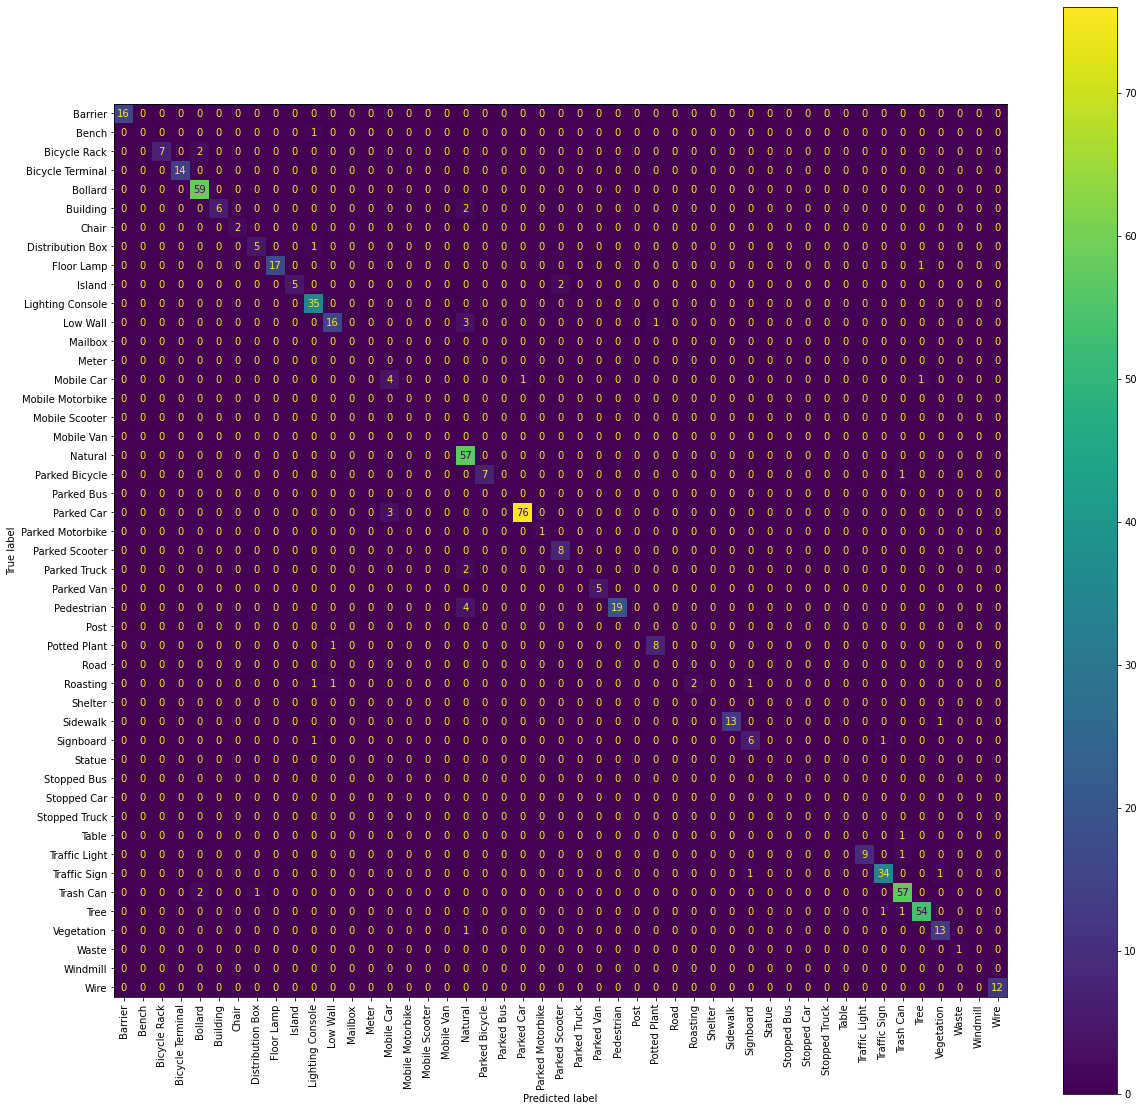

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
cmd = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cmd.plot(ax=ax, xticks_rotation='vertical');

plt.savefig('confusionmatrix_adaboost.png', dpi=600)

# **FEATURE IMPORTANCE**

In [40]:
importance = best_model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.05177
Feature: 1, Score: 0.04087
Feature: 2, Score: 0.13351
Feature: 3, Score: 0.17711
Feature: 4, Score: 0.09537
Feature: 5, Score: 0.11989
Feature: 6, Score: 0.05177
Feature: 7, Score: 0.12807
Feature: 8, Score: 0.20163


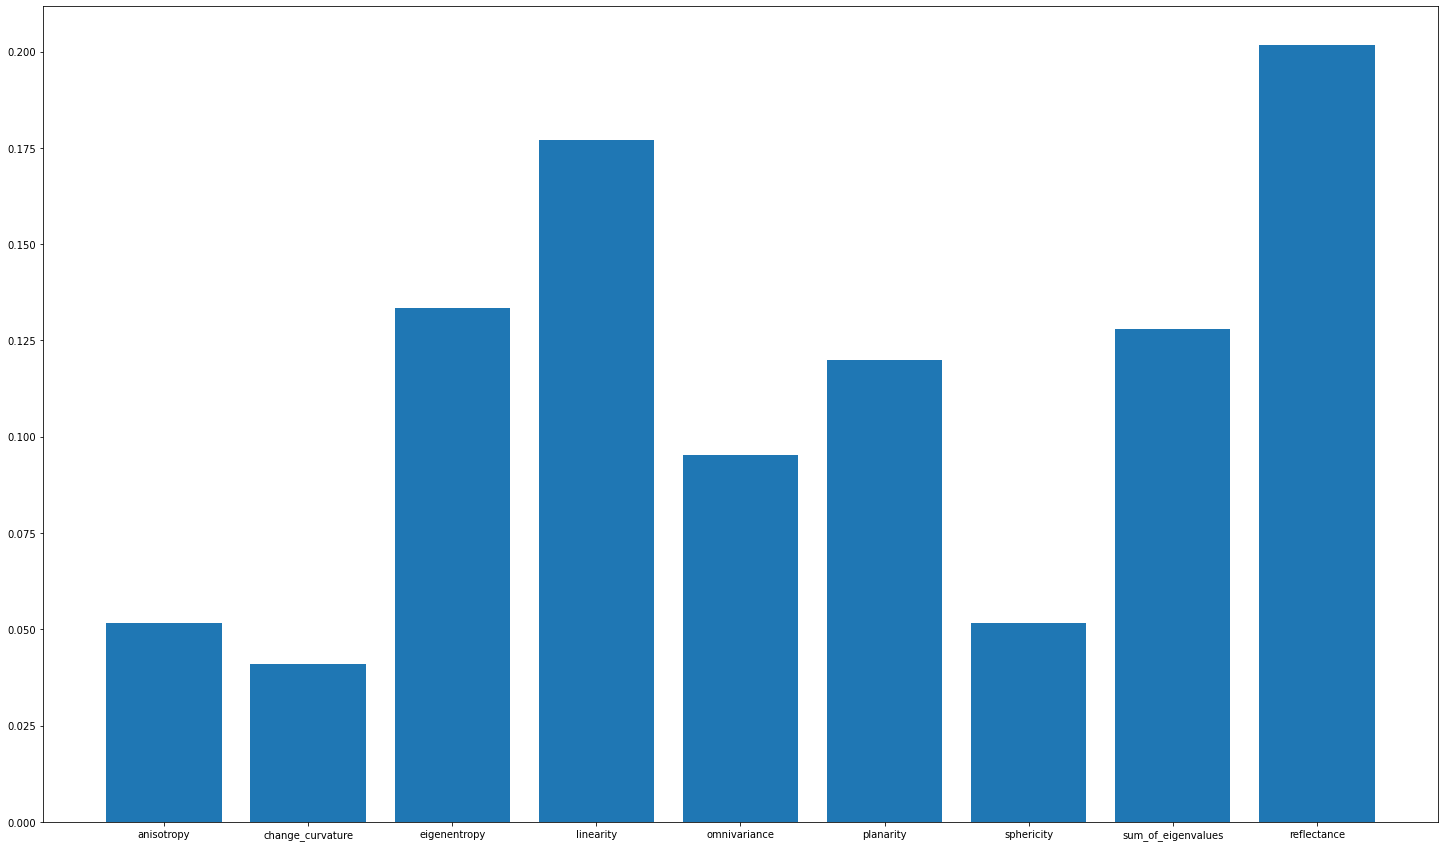

In [41]:
plt.figure(figsize=(25,15))
plt.bar( range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.xticks(range(len(best_model.feature_importances_)), X.columns)
plt.savefig('featureimportance_adaboost.png', dpi=600)
plt.show()